<a href="https://colab.research.google.com/github/ahana2611/Self-study-Projects/blob/main/forecasting_using_moving_average_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
#import the required packages
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, AutoDateLocator

In [45]:
#Importing files
from google.colab import files
uploaded = files.upload()  # This opens a file picker

Saving widget_sales.csv to widget_sales (1).csv


In [46]:
#loading the files
sales = pd.read_csv("widget_sales.csv")

#display the first few instances
display(sales.head())


,date,widget_sales
0,2019-01-01,50.496714
1,2019-01-02,50.805493
2,2019-01-03,51.477758
3,2019-01-04,53.542228
4,2019-01-05,54.873108


In [48]:
#display the last few instances
display(sales.tail())

,date,widget_sales
495,2020-05-10,64.087371
496,2020-05-11,63.992081
497,2020-05-12,63.029894
498,2020-05-13,61.671797
499,2020-05-14,59.443839


In [49]:
#print the shape of the data - here we have 500 instances and 2 features (i.e, widget sales and date)
print(sales.shape)

(500, 2)


In [50]:
print(sales.describe())

       widget_sales
count    500.000000
mean      46.969858
std       15.382473
min       20.674946
25%       32.507149
50%       47.667536
75%       59.425693
max       82.922496


In [53]:
#check for stationarity using Augmented Dickey-Fuller Test
sales_adf_results = adfuller(sales["widget_sales"])
print(f"ADF Statistic:  {sales_adf_results[0].round(2)}")
print(f"Critical value:  {sales_adf_results[4]}")
print(f"p-Value: {sales_adf_results[1].round(2)}")

ADF Statistic:  -1.51
Critical value:  {'1%': np.float64(-3.4436029548776395), '5%': np.float64(-2.867384756137026), '10%': np.float64(-2.5698830308597813)}
p-Value: 0.53


In [54]:
sales_diff = np.diff(sales["widget_sales"])

In [57]:
sales_diff_adf_results = adfuller(sales_diff)

print(f"ADF diff Statistic:  {sales_diff_adf_results[0].round(2)}")
print(f"Critical value:  {sales_diff_adf_results[4]}")
print(f"diff p-Value: {sales_diff_adf_results[1].round(2)}")

ADF diff Statistic:  -10.58
Critical value:  {'1%': np.float64(-3.4436029548776395), '5%': np.float64(-2.867384756137026), '10%': np.float64(-2.5698830308597813)}
diff p-Value: 0.0


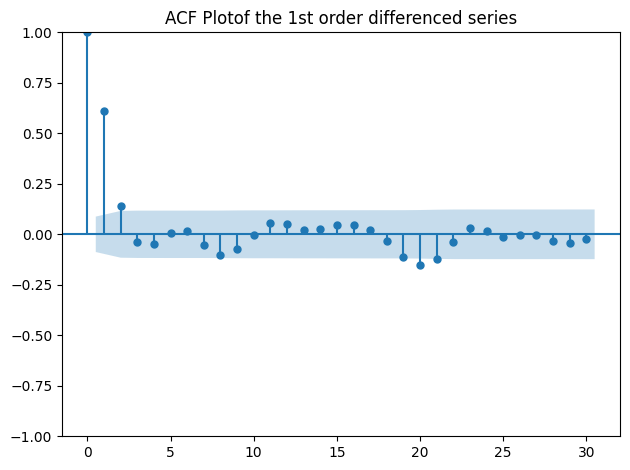

In [58]:
plot_acf(sales_diff, lags=30, title = "ACF Plotof the 1st order differenced series")
plt.tight_layout()

In [59]:
sales_diff_df = pd.DataFrame({"date":sales['date'][1:], "sales_diff": sales_diff})

In [24]:
display(sales_diff_df)

,date,sales_diff
1,2019-01-02,0.308778
2,2019-01-03,0.672265
3,2019-01-04,2.064470
4,2019-01-05,1.330880
5,2019-01-06,0.012034
...,...,...
495,2020-05-10,1.651336
496,2020-05-11,-0.095290
497,2020-05-12,-0.962187
498,2020-05-13,-1.358097


In [27]:
X_train = sales_diff_df[:-50]

X_test = sales_diff_df[-50:]

display(X_train.tail())

,date,sales_diff
445,2020-03-21,-0.531086
446,2020-03-22,0.577963
447,2020-03-23,-0.409040
448,2020-03-24,-1.249779
449,2020-03-25,-1.803658


In [28]:
display(X_test.head())

,date,sales_diff
450,2020-03-26,-1.170131
451,2020-03-27,0.580967
452,2020-03-28,-0.144902
453,2020-03-29,-0.096564
454,2020-03-30,-0.372334


In [29]:
print(X_train.shape)

(449, 2)


In [31]:
print(X_test.shape)

(50, 2)


In [32]:
train_len = X_train.shape[0]
test_len = X_test.shape[0]

In [34]:
def rolling_forecast(data, train_len, horizon, window, method):
  total_len = train_len + horizon
  prediction_MA = []
  for i in range(train_len, total_len, window):
    model = SARIMAX(data[:i], order = (0,0,2))
    result = model.fit(disp=False)
    predictions =result.get_prediction(0, i+ window -1)
    oos_predictions = predictions.predicted_mean.iloc[-window:]
    prediction_MA.extend(oos_predictions)
  return prediction_MA


In [36]:
predictions_diff = X_test.copy()
predictions_diff["prediction_MA"] = rolling_forecast(sales_diff_df["sales_diff"],train_len, test_len, 2, "MA")
display(predictions_diff.head())

,date,sales_diff,prediction_MA
450,2020-03-26,-1.170131,-1.078833
451,2020-03-27,0.580967,-0.273309
452,2020-03-28,-0.144902,0.781223
453,2020-03-29,-0.096564,0.234969
454,2020-03-30,-0.372334,0.168994


In [42]:
# Measures the differenced forecasting performance
mse_MA = mean_squared_error(predictions_diff['sales_diff'], predictions_diff['prediction_MA'])

print(f"MSE for MA(2) method: {round(mse_MA, 2)}")


MSE for MA(2) method: 1.95
